Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then run the cells accordingly.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "江詠筑"
COLLABORATORS = "張又仁 陳志誠"

---

Transfer Learning tutorial
====================
This tutorial is adapted from the work of  [Sasank Chilamkurthy](https://chsasank.github.io), available with other tutorials from [the official PyTorch tutorials page](https://pytorch.org/tutorials/index.html).


In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at [cs231n
notes](http://cs231n.github.io/transfer-learning).

Quoting these notes,

    In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Today we will focus on the second scenario, namely **using a pre-trained convolutional neural network as a fixed feature extractor**. To do this, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.




In [ ]:
!pip3 install torch torchvision
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os


## Models

In [ ]:
import torchvision.models as models


alexnet = models.alexnet()
squeezenet = models.squeezenet1_0()
vgg16 = models.vgg16()
resnet18 = models.resnet18()

### AlexNet Architecture

In [ ]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### SqueezeNet

In [ ]:
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
squeezenet = models.squeezenet1_0(pretrained=True)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16_bn = models.vgg16_bn()
print(vgg16_bn)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

The data is available [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip). We are going to download it and extract it to a local directory.



In [ ]:
data_dir = 'hymenoptera_data'

# download data from torch website, then unzip
!if [ ! -d $data_dir ]; then wget https://download.pytorch.org/tutorial/hymenoptera_data.zip && unzip hymenoptera_data.zip; fi

--2021-11-15 07:06:41--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.19.15, 54.230.19.119, 54.230.19.35, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.19.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  72.3MB/s    in 0.6s    

2021-11-15 07:06:42 (72.3 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/t

In [ ]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transform)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

Running on device: cuda:0


In [ ]:
print(dataset_sizes)
print(class_names)

{'train': 244, 'val': 153}
['ants', 'bees']


##Visualize a few training images


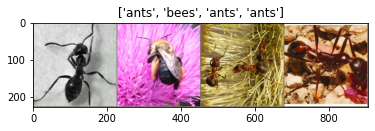

In [ ]:
def imshow(inp, title=None, ax=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
      fig, ax = plt.subplots()
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.grid(False)


# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Load the pre-trained network and set it up for our task

We start by loading a pretrained network. PyTorch makes it easy by having [a built-in library of useful models](https://pytorch.org/docs/stable/torchvision/models.html), that can be loaded with or without their pretrained weights. Let's load the 18-layer version of [ResNet](https://arxiv.org/abs/1512.03385), and ask for the pre-trained weights.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True) 


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Before training, we need to **freeze** all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed when we call ``backward()`` to perform backpropagation.

You can read more about this in the documentation
[here](http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).

In [ ]:
for param in model_conv.parameters():
    param.requires_grad = False # Parameters of newly constructed modules have requires_grad=True by default

Now that we have loaded and frozen the model, we can swap the last fully connected layer with a new layer that we will train for our task. If you observe the output of the print() function above, you will notice that the name of the last layer is `fc`, and that this fully connected layer has 512 input features and 1000 output features (the reason why there are 1000 output features is that this network has been trained to solve the 1000-class classification problem for the [ImageNet 2012](http://www.image-net.org/challenges/LSVRC/2012/) dataset). So we'll need to swap that with another fully connected layer with the same number of inputs (512) but only two outputs, as we are interested in a binary classification problem.


In [ ]:
# knowing that the last layer of the pre-trained network is model_conv.fc, get the number of inputs it has
num_ftrs = model_conv.fc.in_features

# substitute it with a new fully connected layer with the same number of inputs but only 2 outputs
model_conv.fc = nn.Linear(num_ftrs, 2)

In [ ]:
print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train and evaluate


We are now ready to train the model.

In [ ]:
# move the model to the GPU if available
model_conv = model_conv.to(device)

# define cross entropy loss
criterion = nn.CrossEntropyLoss()

# define the optimizer. Note that we tell the optimizer to only update the 
# parameters in the last layer. Also, remember that we have set requires_grad=False
# on all other parameters of the model, so the optimizer wouldn't have gradient
# information on them if we asked it to update all the parameters.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# generic training function
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [ ]:
train_model(model_conv, criterion, optimizer_conv, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5926 Acc: 0.7254
val Loss: 0.2042 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4054 Acc: 0.8197
val Loss: 0.2308 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.3703 Acc: 0.8197
val Loss: 0.1899 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4766 Acc: 0.8033
val Loss: 0.1556 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.6818 Acc: 0.7172
val Loss: 0.2515 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3328 Acc: 0.8525
val Loss: 0.3099 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.2765 Acc: 0.8893
val Loss: 0.1903 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.5787 Acc: 0.7541
val Loss: 0.7666 Acc: 0.7843

Epoch 8/24
----------
train Loss: 0.7179 Acc: 0.7910
val Loss: 0.6078 Acc: 0.8170

Epoch 9/24
----------
train Loss: 0.4696 Acc: 0.8361
val Loss: 0.3482 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.3932 Acc: 0.8648
val Loss: 0.3821 Acc: 0.8758

Epoch 11/24
----------
train Loss: 0.2987 Acc: 0.8811
val Loss: 0.1940 Acc: 0.9477

Ep

Part A. Save and Load your trained model weights

https://pytorch.org/tutorials/beginner/saving_loading_models.html

You could use torch.save(model.state_dict(), '/content/ants_bees_model.pth') to save your model with good results.
You could download it to your computer first, and upload to your individual folder. You could get the Google Drive ID by right clicking 'share.' Use the Google Drive ID for gdown to download to '/content/ants_bees_model.pth'



In [ ]:
import gdown

In [ ]:
# Please load your model from your saved model located in your individual folder
# this will make sure that the accuracy is higher than 0.93

torch.save(model_conv.state_dict(),'/content/ants_bees_model.pth')
id = '15Obb3elRVGLpGOAHNvhIoDERoiveFjEZ'
model_url = 'https://drive.google.com/uc?id=' + id
gdown.download(model_url,output = '/content/ants_bees_model.pth',quiet=False)

model_conv.load_state_dict(torch.load('/content/ants_bees_model.pth'))

Downloading...
From: https://drive.google.com/uc?id=15Obb3elRVGLpGOAHNvhIoDERoiveFjEZ
To: /content/ants_bees_model.pth
100%|██████████| 44.8M/44.8M [00:00<00:00, 189MB/s]


<All keys matched successfully>

## Visualize predictions

In [ ]:
# generic function to visualize predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10,10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j], ax=ax)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

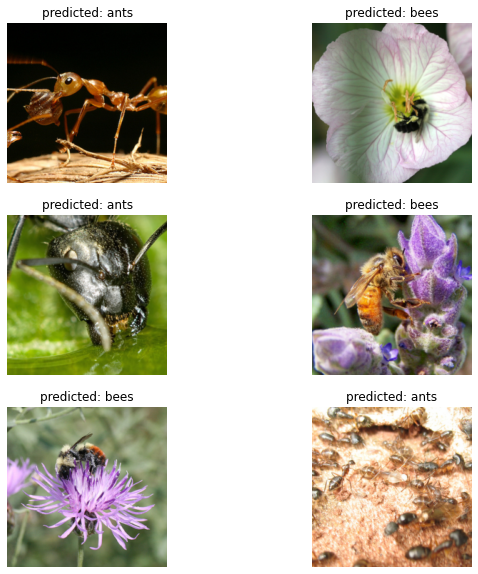

In [ ]:
visualize_model(model_conv)

## Confusion Matrix

[[66  4]
 [ 6 77]]
0.934640522875817


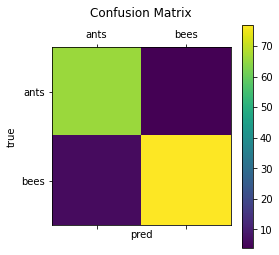

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.font_manager import FontProperties

list_label = []
list_pred = []

for i, (inputs, labels) in enumerate(dataloaders['val']):
  inputs = inputs.to(device)
  labels = labels.to(device)

  outputs = model_conv(inputs)
  _, preds = torch.max(outputs, 1)

  for j in range(inputs.size()[0]):
    list_label.append(labels[j].cpu())
    list_pred.append(preds[j].cpu())

y_true = list_label
y_pred = list_pred
maxtrix = confusion_matrix(y_true, y_pred)

print(maxtrix)
print((maxtrix[0, 0] + maxtrix[1, 1]) / 153)

plt.matshow(maxtrix)
plt.colorbar()
plt.title('Confusion Matrix'+'\n')
plt.xlabel('pred')
plt.ylabel('true')
plt.xticks(np.arange(maxtrix.shape[1]),['ants', 'bees'])
plt.yticks(np.arange(maxtrix.shape[1]),['ants', 'bees'])
plt.show()

In [ ]:
assert (maxtrix[0, 0] + maxtrix[1, 1]) / 153 > 0.93